## This notebook extracts all STN (subregion) signals from the functional data

Masks were manually delineated using the FLASH t2*-weighted image in 0.5mm isotropic resolution. Afterwards, a PCA was applied to each individual STN to define three perpendicular axes, and the STN was cut into three equivolume segments along the ventromedial-dorsolateral axis.

- A = posterior-dorsolateral
- B = central
- C = Anterior-ventromedial

In this notebook, we down-sample these masks to 1.5mm (EPI) resolution, and extract voxel-wise signals from all subregions separately.

In [1]:
import nibabel as nib
import nilearn
from nilearn import plotting, image
import nideconv
from nideconv.utils import roi
import nighres
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
import pandas as pd
import os
import seaborn as sns
from copy import deepcopy
import itertools
import multiprocessing as mp
from functools import partial


%matplotlib inline

/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C 

## Extract timeseries of STN subregions
Using manually delineated masks from GdH and the subsequent PCA decomposition to divide in 3 subrois.

In [2]:
all_masks = sorted(glob.glob('./derivatives/ds-*/pca_masks/sub-*/anat/*.nii.gz'))
all_masks

['./derivatives/ds-01/pca_masks/sub-01/anat/sub-01_desc-stnl_space-T1w_res-1p5mm_roi.nii.gz',
 './derivatives/ds-01/pca_masks/sub-01/anat/sub-01_desc-stnl_space-T1w_res-1p5mm_subroi-A_roi.nii.gz',
 './derivatives/ds-01/pca_masks/sub-01/anat/sub-01_desc-stnl_space-T1w_res-1p5mm_subroi-B_roi.nii.gz',
 './derivatives/ds-01/pca_masks/sub-01/anat/sub-01_desc-stnl_space-T1w_res-1p5mm_subroi-C_roi.nii.gz',
 './derivatives/ds-01/pca_masks/sub-01/anat/sub-01_desc-stnl_space-T1w_roi.nii.gz',
 './derivatives/ds-01/pca_masks/sub-01/anat/sub-01_desc-stnl_space-T1w_subroi-A_roi.nii.gz',
 './derivatives/ds-01/pca_masks/sub-01/anat/sub-01_desc-stnl_space-T1w_subroi-B_roi.nii.gz',
 './derivatives/ds-01/pca_masks/sub-01/anat/sub-01_desc-stnl_space-T1w_subroi-C_roi.nii.gz',
 './derivatives/ds-01/pca_masks/sub-01/anat/sub-01_desc-stnr_space-T1w_res-1p5mm_roi.nii.gz',
 './derivatives/ds-01/pca_masks/sub-01/anat/sub-01_desc-stnr_space-T1w_res-1p5mm_subroi-A_roi.nii.gz',
 './derivatives/ds-01/pca_masks/sub-0

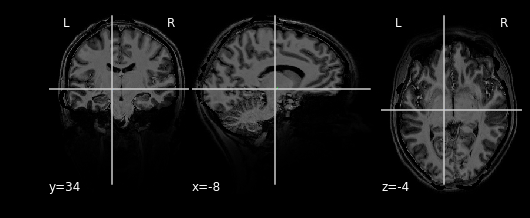

In [88]:
ds = '01'
sub = '01'
mask_name = 'stnl'

mask_nii = nib.load(f'./derivatives/ds-{ds}/pca_masks/sub-{sub}/anat/sub-{sub}_desc-{mask_name}_space-T1w_roi.nii.gz')
t1w_nii = nib.load(f'./derivatives/ds-{ds}/fmriprep/sub-{sub}/anat/sub-{sub}_desc-preproc_T1w.nii.gz')

plotting.plot_roi(mask_nii, bg_img=t1w_nii)

These masks are in T1w-space with T1w native resolution. First downsample all these masks to EPI resolution

### Downsample

In [74]:
all_dirs = sorted(glob.glob('./derivatives/ds-*/pca_masks/sub-*/anat'))
reg = re.compile('./derivatives/ds-(?P<ds>\d+)/pca_masks/sub-(?P<sub>\d+)/anat')
reg.match(all_dirs[0]).groupdict()

<>:2: DeprecationWarning: invalid escape sequence \d


{'ds': '02', 'sub': '01'}

In [75]:
def do_downsample(this_dir):
    mask_fn_template = os.path.join(this_dir, 'sub-{sub}_desc-stn{hemisphere}_space-T1w{subroi}_roi.nii.gz')
    epi_fn_template = './derivatives/ds-{ds}/fmriprep/sub-{sub}/func/sub-{sub}_task-randomdotmotion_run-01_space-T1w_boldref.nii.gz'
    sub = reg.match(this_dir).groupdict()['sub']
    
    first_mask = mask_fn_template.format(sub=sub, hemisphere='r', subroi='')
    epi = epi_fn_template.format(**reg.match(this_dir).groupdict())
    print('Registering mask \n{} to epi \n{}'.format(first_mask, epi))

    res = nighres.registration.embedded_antsreg(source_image=first_mask, 
                                                target_image=epi, 
                                                run_rigid=False, run_affine=False, run_syn=False, 
                                                rigid_iterations=0,
                                                affine_iterations=0, 
                                                coarse_iterations=0, 
                                                fine_iterations=0, 
                                                medium_iterations=0, save_data=True, overwrite=True)

    hemispheres = ['l', 'r']
    subrois = ['', '_subroi-A', '_subroi-B', '_subroi-C']
    
    # apply 'registration warp' to all rois and subrois
    for hemisphere in hemispheres:
        for subroi in subrois:
            mask_fn = mask_fn_template.format(sub=sub, hemisphere=hemisphere, subroi=subroi)
            mask_transformed = nighres.registration.apply_coordinate_mappings(image=mask_fn, mapping1=res['mapping'])
            nib.save(mask_transformed['result'], filename=mask_fn.replace('space-T1w_', 'space-T1w_res-1p5mm_'))

In [76]:
with mp.Pool(30) as p:
    p.map(do_downsample, all_dirs)

Registering mask 
./derivatives/ds-02/pca_masks/sub-01/anat/sub-01_desc-stnr_space-T1w_roi.nii.gz to epi 
./derivatives/ds-02/fmriprep/sub-01/func/sub-01_task-randomdotmotion_run-01_space-T1w_boldref.nii.gzRegistering mask 
./derivatives/ds-02/pca_masks/sub-02/anat/sub-02_desc-stnr_space-T1w_roi.nii.gz to epi 
./derivatives/ds-02/fmriprep/sub-02/func/sub-02_task-randomdotmotion_run-01_space-T1w_boldref.nii.gzRegistering mask 
./derivatives/ds-02/pca_masks/sub-05/anat/sub-05_desc-stnr_space-T1w_roi.nii.gz to epi 
./derivatives/ds-02/fmriprep/sub-05/func/sub-05_task-randomdotmotion_run-01_space-T1w_boldref.nii.gzRegistering mask 
./derivatives/ds-02/pca_masks/sub-03/anat/sub-03_desc-stnr_space-T1w_roi.nii.gz to epi 
./derivatives/ds-02/fmriprep/sub-03/func/sub-03_task-randomdotmotion_run-01_space-T1w_boldref.nii.gzRegistering mask 
./derivatives/ds-02/pca_masks/sub-07/anat/sub-07_desc-stnr_space-T1w_roi.nii.gz to epi 
./derivatives/ds-02/fmriprep/sub-07/func/sub-07_task-randomdotmotion_r


Saving ./derivatives/ds-02/pca_masks/sub-13/anat/sub-13_desc-stnr_space-T1w_roi_tmp_srccoord.nii.gz

Saving ./derivatives/ds-02/pca_masks/sub-11/anat/sub-11_desc-stnr_space-T1w_roi_tmp_trgcoord.nii.gz
registering ./derivatives/ds-02/pca_masks/sub-11/anat/sub-11_desc-stnr_space-T1w_roi.nii.gz
 to ./derivatives/ds-02/fmriprep/sub-11/func/sub-11_task-randomdotmotion_run-01_space-T1w_boldref.nii.gz
antsRegistration --collapse-output-transforms 1 --dimensionality 3 --initialize-transforms-per-stage 0 --interpolation Linear --output sub-11_desc-stnr_space-T1w_roi_tmp_syn --transform Rigid[0.1] --metric CC[./derivatives/ds-02/fmriprep/sub-11/func/sub-11_task-randomdotmotion_run-01_space-T1w_boldref.nii.gz, ./derivatives/ds-02/pca_masks/sub-11/anat/sub-11_desc-stnr_space-T1w_roi.nii.gz, 1.000, 5, Random, 0.3 ] --convergence [ 0x0x0, 1.0, 2 ] --smoothing-sigmas 3.0x2.0x1.0 --shrink-factors 4x2x1 --use-histogram-matching 0 --winsorize-image-intensities [ 0.001, 0.999 ] --write-composite-transfo

antsApplyTransforms --dimensionality 3 --input-image-type 3 --input ./derivatives/ds-02/pca_masks/sub-12/anat/sub-12_desc-stnr_space-T1w_roi_tmp_srccoord.nii.gz --reference-image ./derivatives/ds-02/fmriprep/sub-12/func/sub-12_task-randomdotmotion_run-01_space-T1w_boldref.nii.gz --interpolation Linear --transform [sub-12_desc-stnr_space-T1w_roi_tmp_syn0GenericAffine.mat, 0] --output ./derivatives/ds-02/pca_masks/sub-12/anat/sub-12_desc-stnr_space-T1w_roi_ants-map.nii.gz
antsApplyTransforms --dimensionality 3 --input-image-type 0 --input ./derivatives/ds-02/pca_masks/sub-05/anat/sub-05_desc-stnr_space-T1w_roi.nii.gz --reference-image ./derivatives/ds-02/fmriprep/sub-05/func/sub-05_task-randomdotmotion_run-01_space-T1w_boldref.nii.gz --interpolation NearestNeighbor --transform [sub-05_desc-stnr_space-T1w_roi_tmp_syn0GenericAffine.mat, 0] --output ./derivatives/ds-02/pca_masks/sub-05/anat/sub-05_desc-stnr_space-T1w_roi_ants-def0.nii.gz
antsApplyTransforms --dimensionality 3 --input-image-

antsApplyTransforms --dimensionality 3 --input-image-type 3 --input ./derivatives/ds-02/pca_masks/sub-12/anat/sub-12_desc-stnr_space-T1w_roi_tmp_trgcoord.nii.gz --reference-image ./derivatives/ds-02/pca_masks/sub-12/anat/sub-12_desc-stnr_space-T1w_roi.nii.gz --interpolation Linear --transform [sub-12_desc-stnr_space-T1w_roi_tmp_syn0GenericAffine.mat, 1] --output ./derivatives/ds-02/pca_masks/sub-12/anat/sub-12_desc-stnr_space-T1w_roi_ants-invmap.nii.gz
antsApplyTransforms --dimensionality 3 --input-image-type 3 --input ./derivatives/ds-02/pca_masks/sub-03/anat/sub-03_desc-stnr_space-T1w_roi_tmp_trgcoord.nii.gz --reference-image ./derivatives/ds-02/pca_masks/sub-03/anat/sub-03_desc-stnr_space-T1w_roi.nii.gz --interpolation Linear --transform [sub-03_desc-stnr_space-T1w_roi_tmp_syn0GenericAffine.mat, 1] --output ./derivatives/ds-02/pca_masks/sub-03/anat/sub-03_desc-stnr_space-T1w_roi_ants-invmap.nii.gz
antsApplyTransforms --dimensionality 3 --input-image-type 3 --input ./derivatives/ds-0

In [59]:
!ls ./derivatives/ds-02/pca_masks/sub-01/anat/

sub-01_desc-stnl_space-T1w_res-1p5mm_roi.nii.gz
sub-01_desc-stnl_space-T1w_res-1p5mm_subroi-A_roi.nii.gz
sub-01_desc-stnl_space-T1w_res-1p5mm_subroi-B_roi.nii.gz
sub-01_desc-stnl_space-T1w_res-1p5mm_subroi-C_roi.nii.gz
sub-01_desc-stnl_space-T1w_roi.nii.gz
sub-01_desc-stnl_space-T1w_subroi-A_roi.nii.gz
sub-01_desc-stnl_space-T1w_subroi-B_roi.nii.gz
sub-01_desc-stnl_space-T1w_subroi-C_roi.nii.gz
sub-01_desc-stnr_space-T1w_res-1p5mm_roi.nii.gz
sub-01_desc-stnr_space-T1w_res-1p5mm_subroi-A_roi.nii.gz
sub-01_desc-stnr_space-T1w_res-1p5mm_subroi-B_roi.nii.gz
sub-01_desc-stnr_space-T1w_res-1p5mm_subroi-C_roi.nii.gz
sub-01_desc-stnr_space-T1w_roi.nii.gz
sub-01_desc-stnr_space-T1w_roi_ants-def0.nii.gz
sub-01_desc-stnr_space-T1w_roi_ants-invmap.nii.gz
sub-01_desc-stnr_space-T1w_roi_ants-map.nii.gz
sub-01_desc-stnr_space-T1w_subroi-A_roi.nii.gz
sub-01_desc-stnr_space-T1w_subroi-B_roi.nii.gz
sub-01_desc-stnr_space-T1w_subroi-C_roi.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


[[   1.5           0.            0.          -69.69940948]
 [   0.            1.5           0.         -104.32028198]
 [   0.            0.            1.5         -34.30688477]
 [   0.            0.            0.            1.        ]]
[[   1.5           0.            0.          -69.69940948]
 [   0.            1.5           0.         -104.32028198]
 [   0.            0.            1.5         -34.30688477]
 [   0.            0.            0.            1.        ]]
[[   1.5           0.            0.          -69.69940948]
 [   0.            1.5           0.         -104.32028198]
 [   0.            0.            1.5         -34.30688477]
 [   0.            0.            0.            1.        ]]
[[   1.5           0.            0.          -69.69940948]
 [   0.            1.5           0.         -104.32028198]
 [   0.            0.            1.5         -34.30688477]
 [   0.            0.            0.            1.        ]]
[[   1.5           0.            0.          -69.699

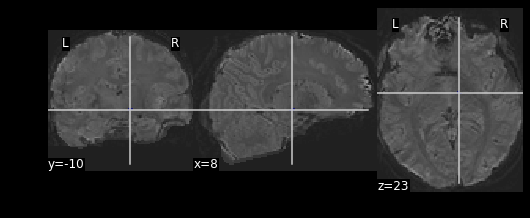

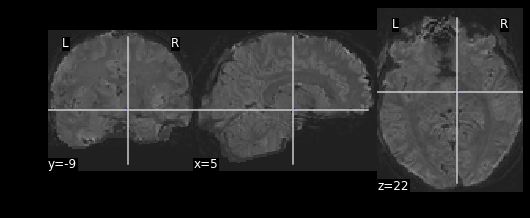

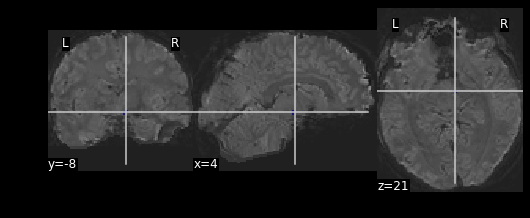

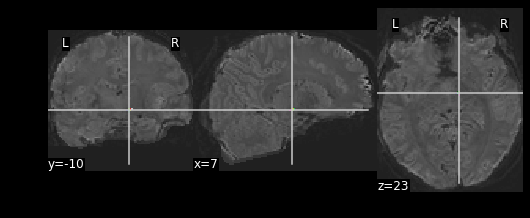

In [3]:
# inspect some random masks
ds = '02'
sub = 2
sub = str(sub).zfill(2)
hemisphere = 'r'

epi = f'./derivatives/ds-{ds}/fmriprep/sub-{sub}/func/sub-{sub}_task-randomdotmotion_run-01_space-T1w_boldref.nii.gz'
maskA = f'./derivatives/ds-{ds}/pca_masks/sub-{sub}/anat/sub-{sub}_desc-stn{hemisphere}_space-T1w_res-1p5mm_subroi-A_roi.nii.gz'
maskB = f'./derivatives/ds-{ds}/pca_masks/sub-{sub}/anat/sub-{sub}_desc-stn{hemisphere}_space-T1w_res-1p5mm_subroi-B_roi.nii.gz'
maskC = f'./derivatives/ds-{ds}/pca_masks/sub-{sub}/anat/sub-{sub}_desc-stn{hemisphere}_space-T1w_res-1p5mm_subroi-C_roi.nii.gz'
maskall = f'./derivatives/ds-{ds}/pca_masks/sub-{sub}/anat/sub-{sub}_desc-stn{hemisphere}_space-T1w_res-1p5mm_roi.nii.gz'
plotting.plot_roi(maskA, bg_img=epi)
plotting.plot_roi(maskB, bg_img=epi)
plotting.plot_roi(maskC, bg_img=epi)
plotting.plot_roi(maskall, bg_img=epi)

print(nib.load(epi).affine)
print(nib.load(maskA).affine)
print(nib.load(maskB).affine)
print(nib.load(maskC).affine)
print(nib.load(maskall).affine)

### extract timeseries from epis

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


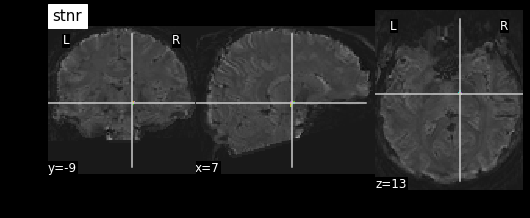

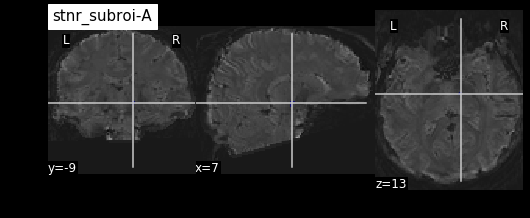

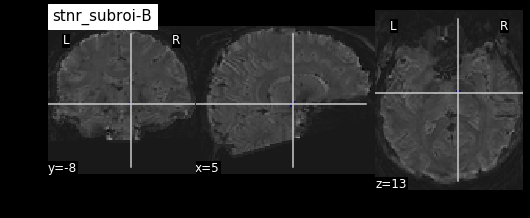

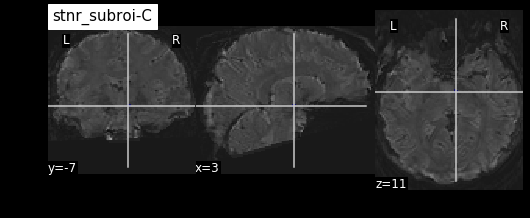

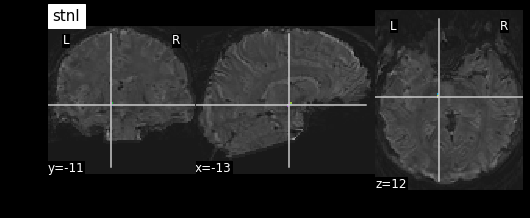

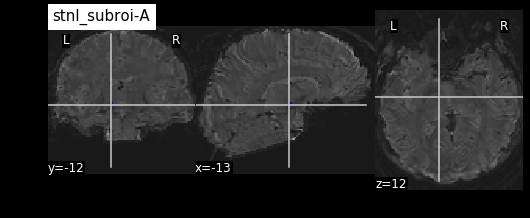

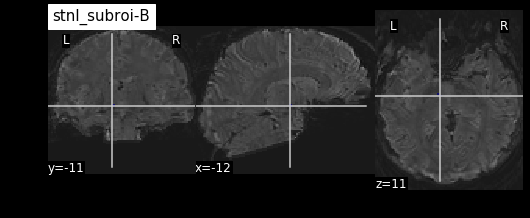

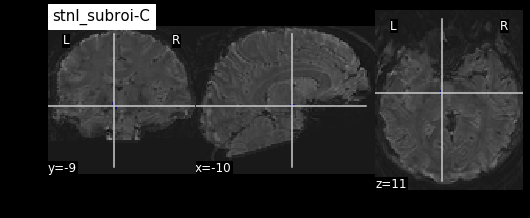

In [55]:
def get_maskfn_label(ds, sub, hemisphere, subregion):
    if subregion == '':
        label = 'stn{}'.format(hemisphere)
    else:
        label = 'stn{}_{}'.format(hemisphere, subregion)
    subregion = '_' + subregion if not subregion == '' else subregion
    return label, f'./derivatives/ds-{ds}/pca_masks/sub-{sub}/anat/sub-{sub}_desc-stn{hemisphere}_space-T1w_res-1p5mm{subregion}_roi.nii.gz'


def make_subject_atlas(ds, sub):
    hemispheres = ['r', 'l']
    subregions = ['', 'subroi-A', 'subroi-B', 'subroi-C']

    labels = []
    imgs = []
    for hemisphere in hemispheres:
        for subregion in subregions:
            label, fn = get_maskfn_label(ds, sub, hemisphere, subregion)
            labels.append(label)
            imgs.append(fn)

    from sklearn.utils import Bunch
    atlas = Bunch(labels=labels, 
                  maps=nilearn.image.concat_imgs(imgs))
    return atlas

def get_epi(ds, sub, run):
    epi = f'./derivatives/ds-{ds}/fmriprep/sub-{sub}/func/sub-{sub}_task-randomdotmotion_run-{run}_space-T1w_desc-preproc_bold.nii.gz'
#     if ds == '01':
#     else:
#         epi = f'./derivatives/ds-{ds}/fmriprep/sub-{sub}/func/sub-{sub}_task-randomdotmotion_run-{run}_bold_space-T1w_preproc.nii.gz'
    return epi

# example
ds = '02'
sub = '01'
atlas = make_subject_atlas(ds, sub)
# for plotting only
epi = f'./derivatives/ds-{ds}/fmriprep/sub-{sub}/func/sub-{sub}_task-randomdotmotion_run-01_space-T1w_boldref.nii.gz'
for i, label in enumerate(atlas.labels):
    plotting.plot_roi(image.index_img(atlas.maps, i), bg_img=epi, title=label)

In [5]:
# How many voxels are in these subregions?
ds = '02'
sub = '02'

atlas = make_subject_atlas(ds, sub)

for i in np.arange(len(atlas.labels)):   
    mask = image.index_img(atlas.maps, i)
    # just manually extract
    mask_flat = mask.get_data().ravel()
    print('Mask: {}, n vox: {}'.format(atlas.labels[i], (mask_flat>0).sum()))

Mask: stnr, n vox: 34
Mask: stnr_subroi-A, n vox: 12
Mask: stnr_subroi-B, n vox: 9
Mask: stnr_subroi-C, n vox: 13
Mask: stnl, n vox: 26
Mask: stnl_subroi-A, n vox: 9
Mask: stnl_subroi-B, n vox: 8
Mask: stnl_subroi-C, n vox: 9


In [9]:
def do_extract(to_run):
    ds, sub, run = to_run
    ds = str(ds).zfill(2)
    sub = str(sub).zfill(2)
    run = str(run).zfill(2)
    print(f'Extracting from ds-{ds}/sub-{sub}/run-{run}', end='')

    epi_fn = get_epi(ds, sub, run)
    if not os.path.exists(epi_fn):
        print('...doesnt exist, skipping'.format(ds, sub, run))
        return 0
    
    atlas = make_subject_atlas(ds, sub)
    epi = nib.load(get_epi(ds, sub, run))
    epi_flat = epi.get_data().reshape((np.product(epi.shape[:3]), epi.shape[-1]))

    for i in np.arange(len(atlas.labels)):
        print('.', end='')
        label = atlas.labels[i]
        mask = image.index_img(atlas.maps, i)
        mask_flat = mask.get_data().ravel()
        signal = pd.DataFrame(epi_flat[mask_flat>0].T)
        signal.index.name = 'volume'

        output_fn = f'./derivatives/ds-{ds}/extracted_signal/sub-{sub}/func/sub-{sub}_task-randomdotmotion_run-{run}_space-T1w_desc-preproc_desc-{label}.csv'
        output_fn

        os.makedirs(os.path.dirname(output_fn), exist_ok=True)
        signal.to_csv(output_fn)

In [10]:
all_combinations = list(itertools.product([1,2], np.arange(1,20), [1,2,3]))

with mp.Pool(30) as p:
    p.map(do_extract, all_combinations)

### Extract other ROIs

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


array([[   1.5,    0. ,    0. ,  -96.5],
       [   0. ,    1.5,    0. , -132.5],
       [   0. ,    0. ,    1.5,  -78.5],
       [   0. ,    0. ,    0. ,    1. ]])

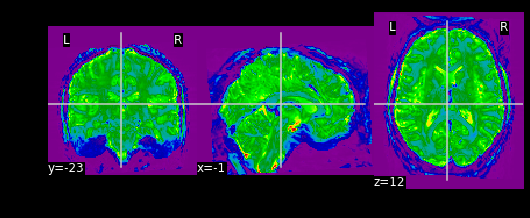

In [2]:
# to 1p5mm epi-space
epi = './derivatives/ds-01/fmriprep/sub-01/func/sub-01_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_boldref.nii.gz'
plotting.plot_epi(epi)
nib.load(epi).affine

In [3]:
all_masks = sorted(glob.glob('./masks/space*Asym_label*probseg.nii.gz'))
first_mask = all_masks[0]

In [42]:
res = nighres.registration.embedded_antsreg(source_image=first_mask, 
                                            target_image=epi, 
                                            run_rigid=False, run_affine=False, run_syn=False, 
                                            rigid_iterations=0,
                                            affine_iterations=0, 
                                            coarse_iterations=0, 
                                            fine_iterations=0, 
                                            medium_iterations=0, save_data=True)
for mask_path in all_masks:
    mask_name = mask_path.split('_')[1].split('-')[1]
    downsampled = nighres.registration.apply_coordinate_mappings(image=mask_path, mapping1=res['mapping'])
    nib.save(downsampled['result'], './masks/space-MNI152NLin2009cAsym_res-1p5mm_label-{}_probseg.nii.gz'.format(mask_name))


Embedded ANTs Registration Multi-contrasts

Outputs will be saved to ./masks/
skip computation (use existing results)

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


21442
12176


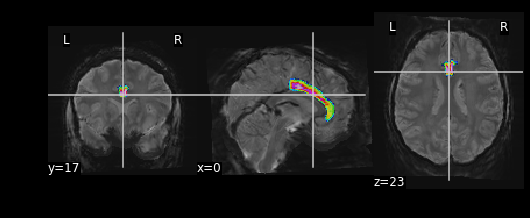

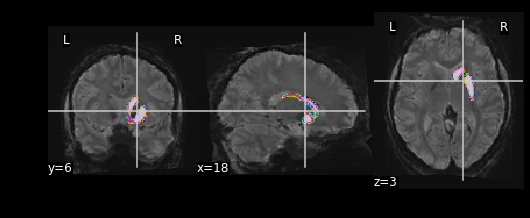

In [43]:
plotting.plot_roi(res['transformed_sources'][0], bg_img=epi)
plotting.plot_roi(downsampled['result'], bg_img=epi)

print((res['transformed_sources'][0].get_data()>0).sum())
print((downsampled['result'].get_data()>0).sum())

In [4]:
all_masks_1p5 = sorted(glob.glob('./masks/*res-1p5mm*'))
all_masks_1p5_labels = [x.split('_')[2].split('-')[1] for x in all_masks_1p5]
all_masks_1p5_labels

['ACC',
 'M1',
 'THA',
 'lGPe',
 'lGPi',
 'lM1',
 'lPreSMA',
 'lSTN',
 'lSTR',
 'rGPe',
 'rGPi',
 'rIFG',
 'rM1',
 'rPreSMA',
 'rSTN',
 'rSTR']

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:942: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:942: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:942: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:942: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:942: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')
/home/stevenm/.conda/envs/python3/lib/python3.6/site-pa

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/ma/core.py:2788: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/ma/core.py:2788: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/ma/core.py:2788: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/ma/core.py:2788: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:942: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotlib/contou

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/ma/core.py:2788: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/ma/core.py:2788: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:942: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:942: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')


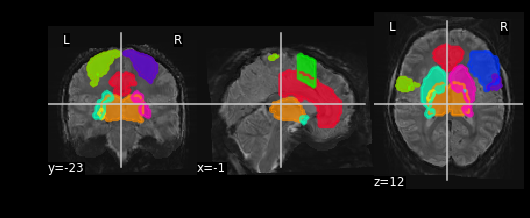

In [5]:
from sklearn.utils import Bunch
ROI_atlas = Bunch(labels=all_masks_1p5_labels, 
                  maps=nilearn.image.concat_imgs(all_masks_1p5))
plotting.plot_prob_atlas(ROI_atlas.maps, bg_img=epi)

### find all functional runs

In [42]:
def get_epi(ds, sub, run):
    epi = f'./derivatives/ds-{ds}/fmriprep/sub-{sub}/func/sub-{sub}_task-randomdotmotion_run-{run}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
    return epi

def do_extract(to_run, atlas):
    ds, sub, run = to_run
    ds = str(ds).zfill(2)
    sub = str(sub).zfill(2)
    run = str(run).zfill(2)
    print(f'Extracting from ds-{ds}/sub-{sub}/run-{run}', end='')

    epi_fn = get_epi(ds, sub, run)
    if not os.path.exists(epi_fn):
        print('...doesnt exist, skipping'.format(ds, sub, run))
        return 0

    epi = nib.load(epi_fn)
    epi_flat = epi.get_data().reshape((np.product(epi.shape[:3]), epi.shape[-1]))

    dfs = []
    for i in np.arange(len(atlas.labels)):
        print('.', end='')
        label = atlas.labels[i]
        mask = image.index_img(atlas.maps, i)
        mask_flat = mask.get_data().ravel()
        signal = pd.DataFrame(np.average(epi_flat, weights=mask_flat, axis=0), columns=[label])
        signal.index.name = 'volume'
        dfs.append(signal)

    df = pd.concat(dfs, axis=1)
    output_fn = '/home/stevenm/bias/derivatives/ds-{}/extracted_signal/sub-{}/func/sub-{}_task-randomdotmotion_run-{}_space-MNI152NLin2009cAsym_desc-preproc_desc-atlasROIs.csv'.format(str(ds).zfill(2), str(sub).zfill(2), str(sub).zfill(2), str(run).zfill(2))
    df.to_csv(output_fn)

In [43]:
# all_combinations = list(itertools.product([1,2], np.arange(1,20), [1,2,3]))
# do_extract(all_combinations[0], atlas=ROI_atlas)

In [44]:
def check_exists(combination):
    ds, sub, run = combination
    ds = str(ds).zfill(2)
    sub = str(sub).zfill(2)
    run = str(run).zfill(2)

    epi_fn = get_epi(ds, sub, run)
    if not os.path.exists(epi_fn):
        return 0
    else:
        return 1

In [45]:
all_combinations = list(itertools.product([1,2], np.arange(1,20), [1,2,3]))
to_run = [x for x in all_combinations if check_exists(x)]

In [46]:
with mp.Pool(15) as p:
    p.map(partial(do_extract, atlas=ROI_atlas), to_run)

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-pac

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-pac